# Clustering Fashion Items (Images)

## 1. Load The Dataset

In [42]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE

In [6]:
# Load Fashion MNIST dataset using kagglehub
train_data = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "zalando-research/fashionmnist",
    "fashion-mnist_train.csv"
)

test_data = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "zalando-research/fashionmnist",
    "fashion-mnist_test.csv"
)

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

/var/folders/r4/nbsvc52j2k95485rssc1nvq40000gn/T/ipykernel_26309/913238977.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  train_data = kagglehub.load_dataset(


100%|██████████| 33.6M/33.6M [00:07<00:00, 4.99MB/s]

Extracting zip of fashion-mnist_train.csv...



/var/folders/r4/nbsvc52j2k95485rssc1nvq40000gn/T/ipykernel_26309/913238977.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  test_data = kagglehub.load_dataset(


100%|██████████| 5.59M/5.59M [00:01<00:00, 4.06MB/s]

Extracting zip of fashion-mnist_test.csv...


Training data shape: (60000, 785)
Test data shape: (10000, 785)


In [7]:
# Extract features and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [8]:
# Reshape images to 28x28 for visualization
X_train_images = X_train.reshape(-1, 28, 28)
X_test_images = X_test.reshape(-1, 28, 28)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

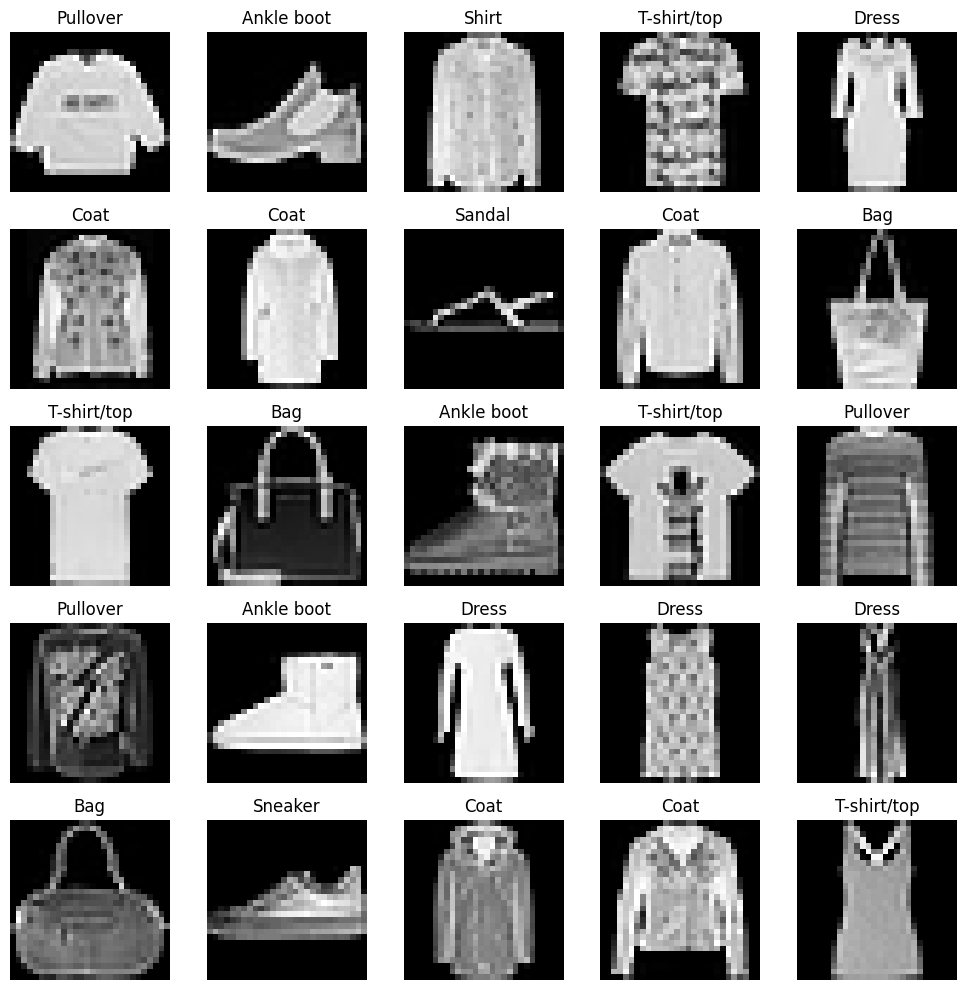

In [ ]:
# Show some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train_images[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [14]:
# Let's assume a subset of the data for faster computation for now
n_samples = 10000
X_sample = X_train[:n_samples]
y_sample = y_train[:n_samples]

print(f"Original shape: {X_sample.shape}")

Original shape: (10000, 784)


In [15]:
# Normalize pixel values to 0-1
X_sample = X_sample / 255.0

## 3. PCA for Dimensionality Reduction

In [16]:
# Find the optimal number of components
pca = PCA().fit(X_sample)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

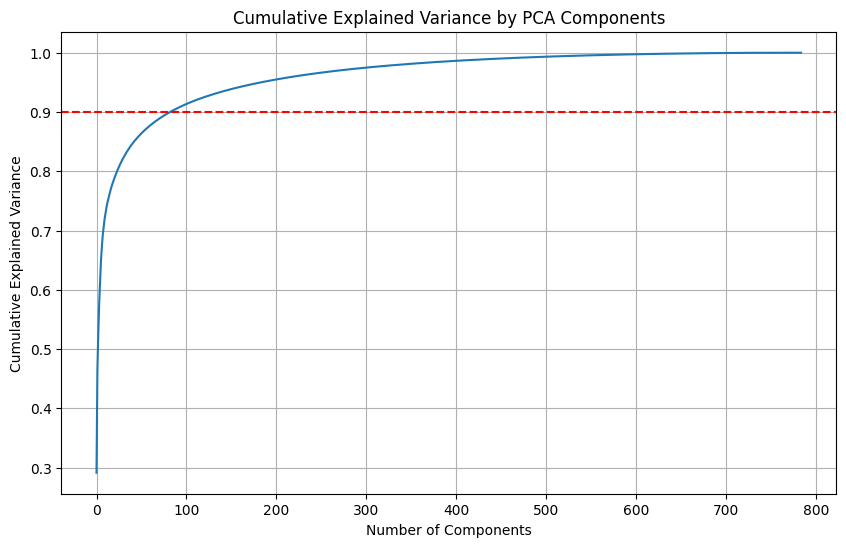

In [17]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid()
plt.show()

In [18]:
# Choose number of components that explain 90% of variance
n_components = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components for 90% variance: {n_components}")

Number of components for 90% variance: 83


In [19]:
# Apply PCA with selected components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_sample)
print(f"PCA shape: {X_pca.shape}")

PCA shape: (10000, 83)


## 4. K-means Clustering

In [20]:
# We know there are 10 classes in Fashion MNIST, so we'll use k=10
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

In [21]:
# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_pca, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.18274635858974783


In [ ]:
# Create a 2D visualization with TSNE for visualization purposes
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

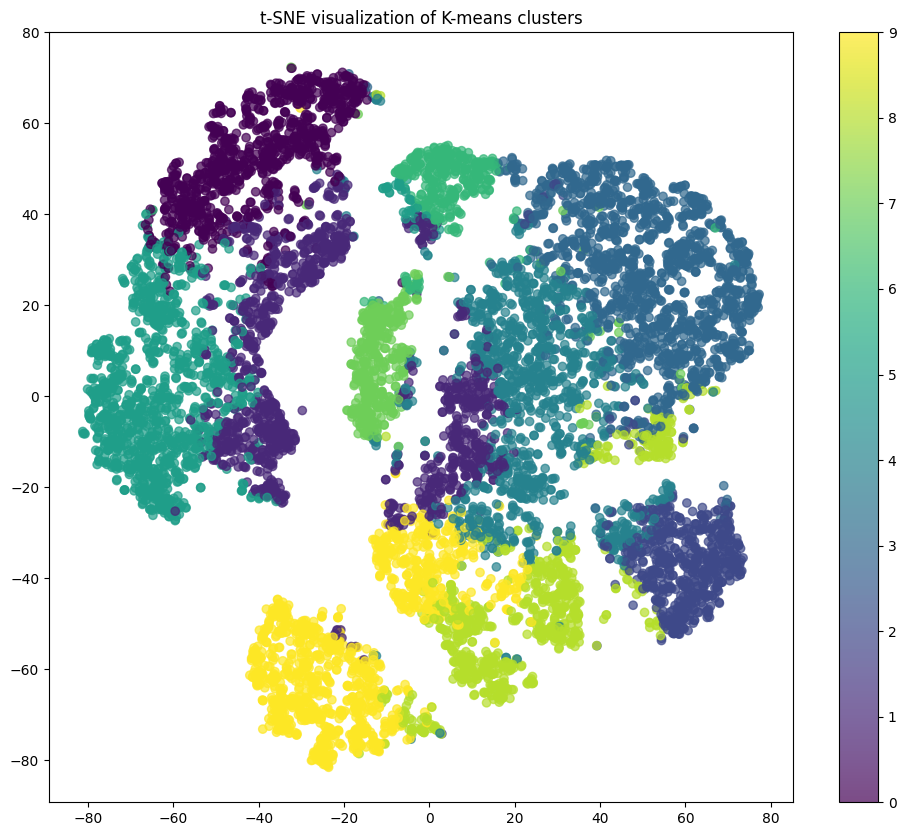

In [23]:
# Plot the clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE visualization of K-means clusters')
plt.show()

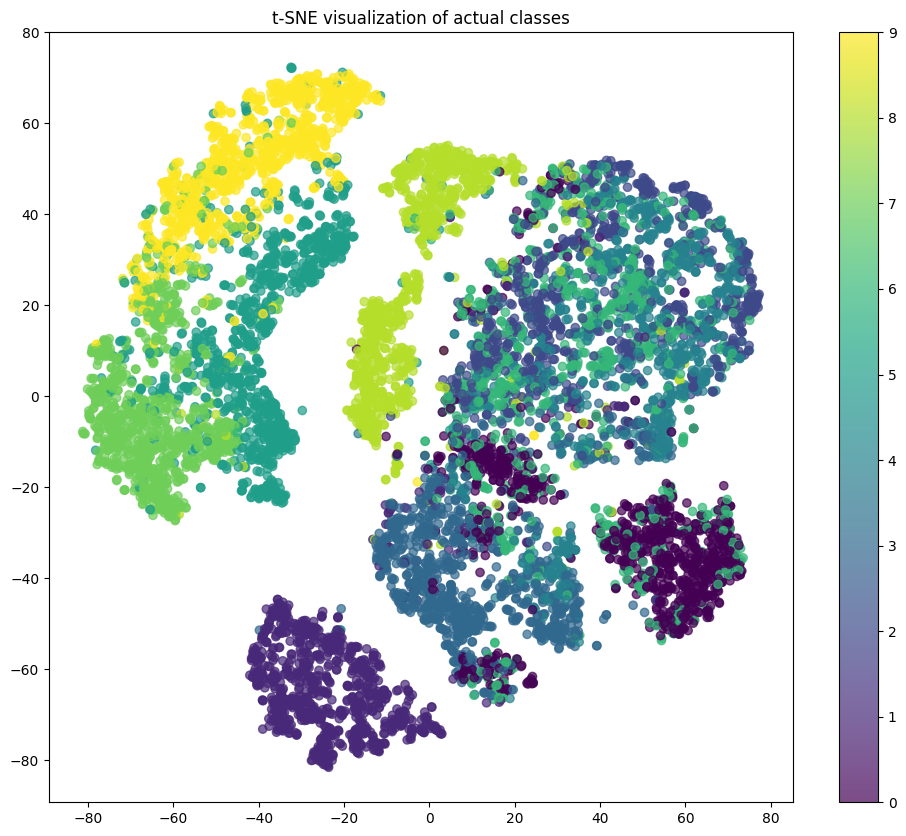

In [24]:
# Plot the actual classes
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE visualization of actual classes')
plt.show()

## 5. Interpret Clusters

In [25]:
# Confusion matrix between clusters and true labels
conf_matrix = confusion_matrix(y_sample, clusters)

In [26]:
# Normalize confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

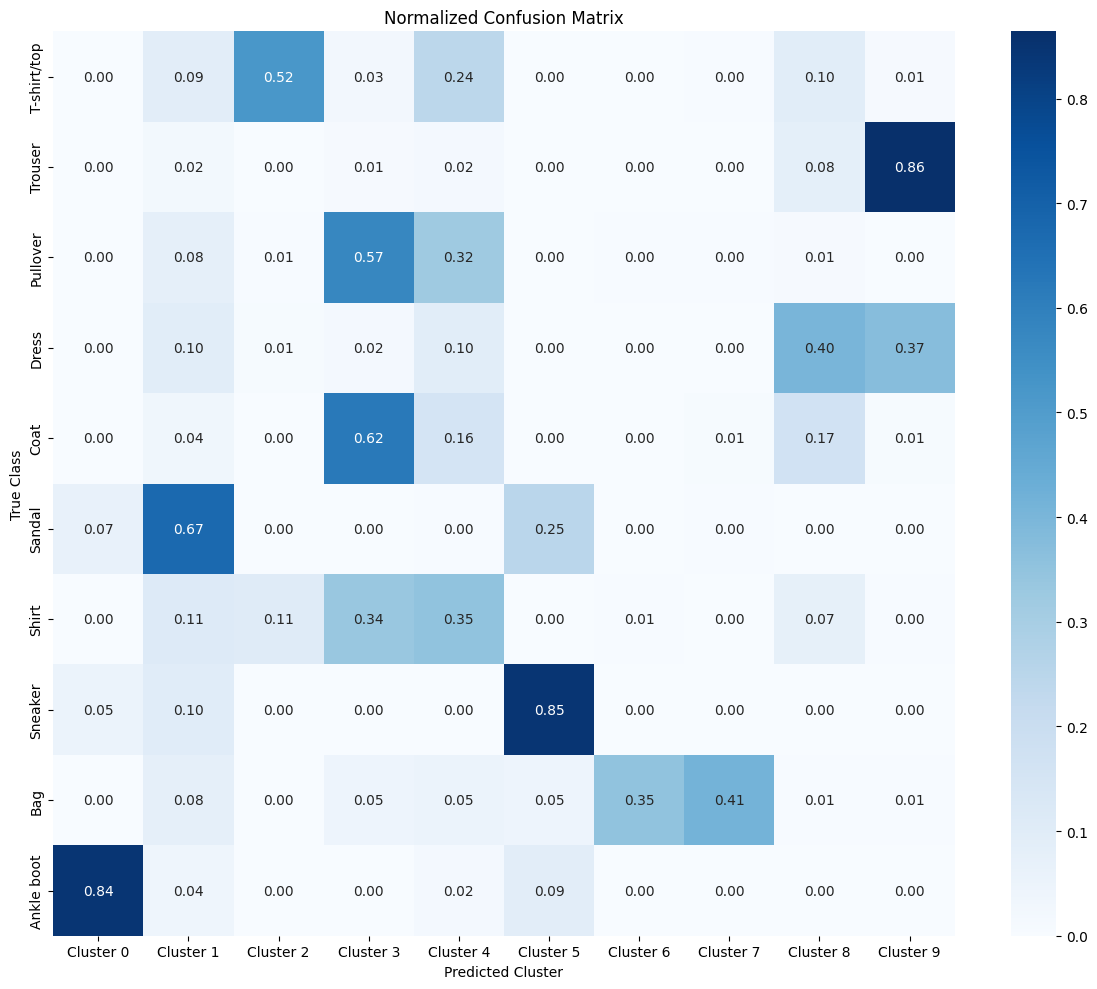

In [27]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'Cluster {i}' for i in range(10)], 
            yticklabels=class_names)
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

In [29]:
def purity_score(y_true, y_pred):
    """
    Compute purity for clustering evaluation
    """
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [31]:
purity = purity_score(y_sample, clusters)
print(f"Cluster Purity: {purity:.4f}")

Cluster Purity: 0.5921


In [32]:
# Assign each cluster to its most frequent class
cluster_to_class = {}
for cluster in range(10):
    mask = clusters == cluster
    if np.any(mask):
        most_common_class = np.bincount(y_sample[mask]).argmax()
        cluster_to_class[cluster] = most_common_class
        print(f"Cluster {cluster} -> {class_names[most_common_class]}")

Cluster 0 -> Ankle boot
Cluster 1 -> Sandal
Cluster 2 -> T-shirt/top
Cluster 3 -> Coat
Cluster 4 -> Shirt
Cluster 5 -> Sneaker
Cluster 6 -> Bag
Cluster 7 -> Bag
Cluster 8 -> Dress
Cluster 9 -> Trouser


In [33]:
# Map clusters back to class labels
remapped_clusters = np.array([cluster_to_class.get(cluster, -1) for cluster in clusters])

In [34]:
# Calculate accuracy after remapping
accuracy = accuracy_score(y_sample, remapped_clusters)
print(f"Remapped Accuracy: {accuracy:.4f}")

Remapped Accuracy: 0.5921


The accuracy did not change after remapping

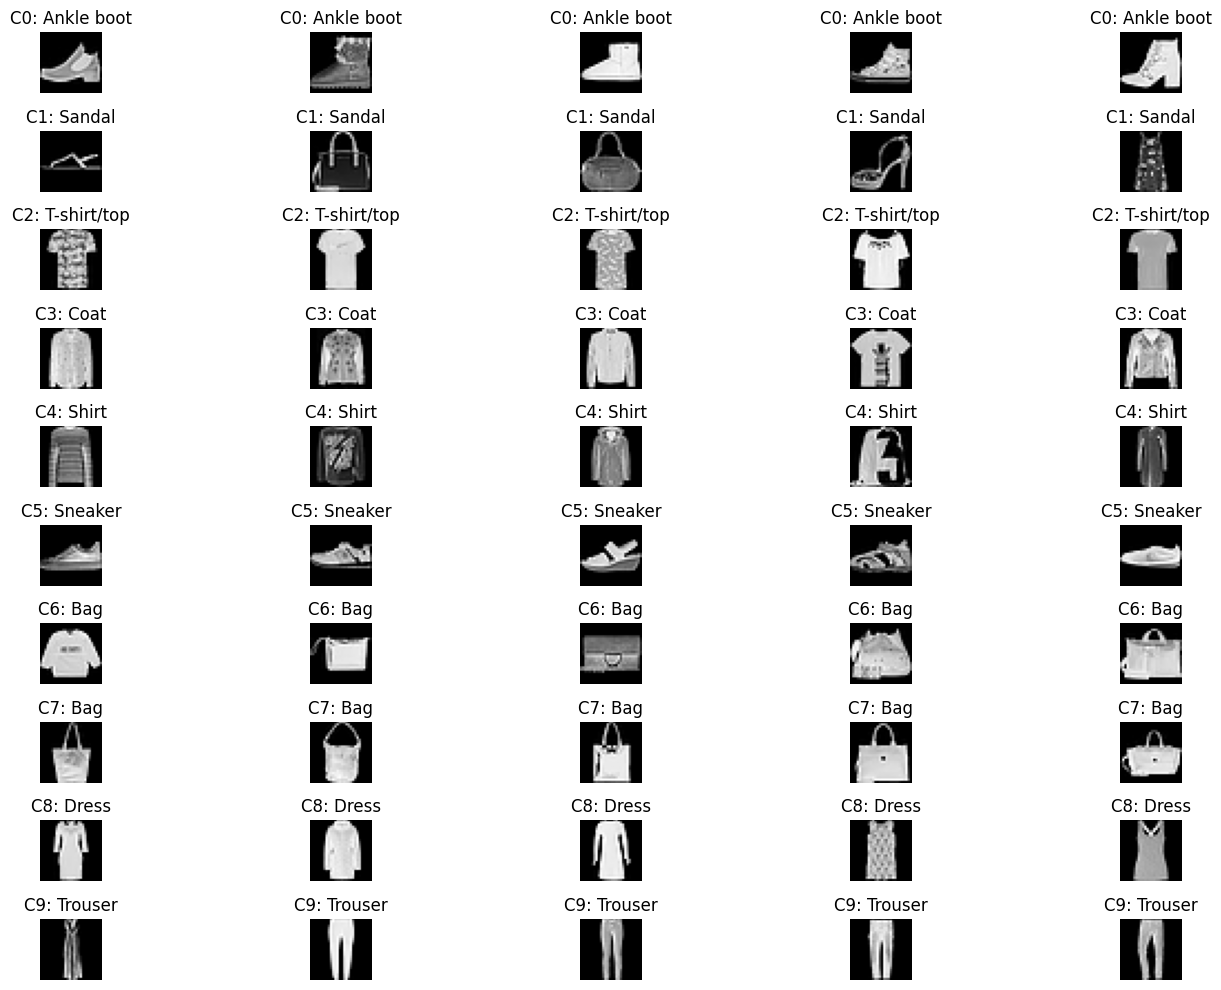

In [35]:
# Visualize each cluster
plt.figure(figsize=(15, 10))
for cluster in range(10):
    cluster_indices = np.where(clusters == cluster)[0]
    if len(cluster_indices) == 0:
        continue
        
    # Most frequent class in this cluster
    mask = clusters == cluster
    most_common_class = np.bincount(y_sample[mask]).argmax()
    true_class_name = class_names[most_common_class]
    
    # Display 5 examples from this cluster
    for i in range(min(5, len(cluster_indices))):
        plt.subplot(10, 5, cluster*5 + i + 1)
        plt.imshow(X_train_images[cluster_indices[i]], cmap='gray')
        plt.title(f'C{cluster}: {true_class_name}')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Try different numbers of clusters
silhouette_scores = []
k_values = range(2, 21)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, clusters)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

K=2, Silhouette Score: 0.2174
K=3, Silhouette Score: 0.2147
K=4, Silhouette Score: 0.2075
K=5, Silhouette Score: 0.1925
K=6, Silhouette Score: 0.1859
K=7, Silhouette Score: 0.1958
K=8, Silhouette Score: 0.1839
K=9, Silhouette Score: 0.1869
K=10, Silhouette Score: 0.1827
K=11, Silhouette Score: 0.1842
K=12, Silhouette Score: 0.1713
K=13, Silhouette Score: 0.1649
K=14, Silhouette Score: 0.1651
K=15, Silhouette Score: 0.1624
K=16, Silhouette Score: 0.1552
K=17, Silhouette Score: 0.1560
K=18, Silhouette Score: 0.1550
K=19, Silhouette Score: 0.1515
K=20, Silhouette Score: 0.1479


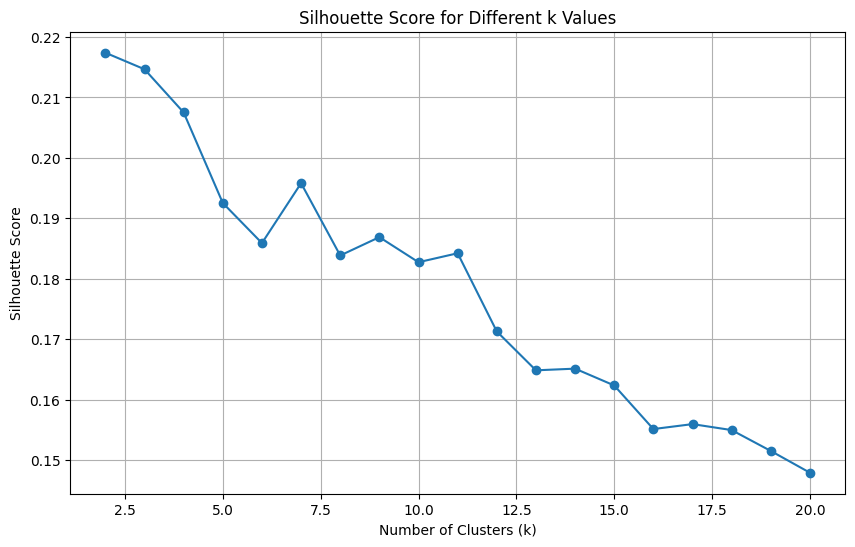

In [37]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k Values')
plt.grid()
plt.show()

In [43]:
print("Cluster Composition Report:")
for cluster in range(10):
    mask = clusters == cluster
    if np.any(mask):
        cluster_labels = y_sample[mask]
        total = len(cluster_labels)
        print(f"\nCluster {cluster} (mapped to {class_names[cluster_to_class[cluster]]}):")
        print(f"Total items: {total}")
        print("Class distribution:")
        for label in np.unique(cluster_labels):
            count = np.sum(cluster_labels == label)
            percentage = (count / total) * 100
            print(f"  - {class_names[label]}: {count} items ({percentage:.1f}%)")

Cluster Composition Report:

Cluster 0 (mapped to Ankle boot):
Total items: 462
Class distribution:
  - T-shirt/top: 1 items (0.2%)
  - Trouser: 3 items (0.6%)
  - Pullover: 218 items (47.2%)
  - Coat: 200 items (43.3%)
  - Shirt: 38 items (8.2%)
  - Bag: 2 items (0.4%)

Cluster 1 (mapped to Sandal):
Total items: 649
Class distribution:
  - Sandal: 61 items (9.4%)
  - Sneaker: 578 items (89.1%)
  - Bag: 9 items (1.4%)
  - Ankle boot: 1 items (0.2%)

Cluster 2 (mapped to T-shirt/top):
Total items: 672
Class distribution:
  - T-shirt/top: 20 items (3.0%)
  - Trouser: 8 items (1.2%)
  - Pullover: 261 items (38.8%)
  - Dress: 9 items (1.3%)
  - Coat: 137 items (20.4%)
  - Shirt: 214 items (31.8%)
  - Bag: 19 items (2.8%)
  - Ankle boot: 4 items (0.6%)

Cluster 3 (mapped to Coat):
Total items: 501
Class distribution:
  - T-shirt/top: 10 items (2.0%)
  - Trouser: 234 items (46.7%)
  - Pullover: 1 items (0.2%)
  - Dress: 234 items (46.7%)
  - Coat: 8 items (1.6%)
  - Shirt: 4 items (0.8%)
  -

---

## 6. Findings
1. PCA reduced dimensions from 784 to 83 while preserving 90% of variance
2. K-means with k=10 achieved purity of 0.5921
3. After remapping clusters to most common class, accuracy is 0.5921
4. Clusters generally align with garment categories, with some confusion between similar items